In [4]:
import requests
import pandas as pd
from pprint import pprint

HOST = "https://api.census.gov/data"
year = "2018"
dataset = "acs/acs5"
base_url = "/".join([HOST, year, dataset])

print(base_url)

https://api.census.gov/data/2018/acs/acs5


In [5]:
# Build the list of variables to request
get_vars = ["NAME", "B19013_001E"]

print(get_vars)

['NAME', 'B19013_001E']


In [6]:
predicates = {}
predicates["get"] = ",".join(get_vars)
predicates["for"] = "state:*"
# predicates["key"] = ____________________

print(predicates)

{'get': 'NAME,B19013_001E', 'for': 'state:*'}


In [7]:
r = requests.get(base_url, params=predicates)

print(r.url)

https://api.census.gov/data/2018/acs/acs5?get=NAME%2CB19013_001E&for=state%3A%2A


In [8]:
print(r.text)

[["NAME","B19013_001E","state"],
["Minnesota","68411","27"],
["Mississippi","43567","28"],
["Missouri","53560","29"],
["Montana","52559","30"],
["Nebraska","59116","31"],
["Nevada","57598","32"],
["New Hampshire","74057","33"],
["New Jersey","79363","34"],
["New Mexico","48059","35"],
["New York","65323","36"],
["North Carolina","52413","37"],
["North Dakota","63473","38"],
["Ohio","54533","39"],
["Oklahoma","51424","40"],
["Oregon","59393","41"],
["Pennsylvania","59445","42"],
["Rhode Island","63296","44"],
["South Carolina","51015","45"],
["South Dakota","56499","46"],
["Tennessee","50972","47"],
["Texas","59570","48"],
["Utah","68374","49"],
["Vermont","60076","50"],
["Virginia","71564","51"],
["West Virginia","44921","54"],
["Washington","70116","53"],
["Wisconsin","59209","55"],
["Wyoming","62268","56"],
["Puerto Rico","20166","72"],
["Alabama","48486","01"],
["Alaska","76715","02"],
["Arizona","56213","04"],
["Arkansas","45726","05"],
["California","71228","06"],
["Colorado","688

In [9]:
# response.text is useful for diagnosing problems in the request
missing_vars = ["this_does_not_exist"]
predicates["get"] = predicates["get"] = ",".join(missing_vars)

r2 = requests.get(base_url, params=predicates)

print(r2.text)

error: error: unknown variable 'this_does_not_exist'


In [10]:
# Repair the variables...
predicates["get"] = ",".join(get_vars)

# ...but screw up the geography
predicates["for"] = "statd:*"

r2 = requests.get(base_url, params=predicates)

print(r2.text)

error: unknown/unsupported geography heirarchy


In [11]:
pprint(r.json()[:5])

[['NAME', 'B19013_001E', 'state'],
 ['Minnesota', '68411', '27'],
 ['Mississippi', '43567', '28'],
 ['Missouri', '53560', '29'],
 ['Montana', '52559', '30']]


In [12]:
col_names = ["name", "mhi", "state"]
states = pd.DataFrame(columns=col_names, data=r.json()[1:])

# Fix columns that should be numeric
states["mhi"] = states["mhi"].astype(int)

print(states.head())

          name    mhi state
0    Minnesota  68411    27
1  Mississippi  43567    28
2     Missouri  53560    29
3      Montana  52559    30
4     Nebraska  59116    31


In [ ]:
# # Get shapefile of state boundaries
# import os
# from urllib.request import urlopen
# from zipfile import ZipFile

# # data retrieval
# def get_and_unzip(url, data_dir = os.getcwd()):
    
#     basename = url.split("/")[-1]
#     fn = os.path.join(data_dir, basename)
    
#     file_data = urlopen(url)  
#     data_to_write = file_data.read()
#     with open(fn, "wb") as f:  
#         f.write(data_to_write)
    
#     zip_obj = ZipFile(fn)
#     zip_obj.extractall(data_dir)
#     del(zip_obj)
    
#     # Cleanup:
#     os.unlink(fn)

# get_and_unzip("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")

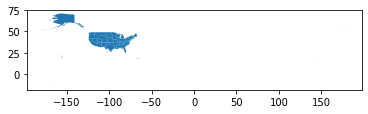

In [13]:
import geopandas as gpd

# Rely on shapefile being downloaded and cached in R session
# Use appropriate path for yourself!
gdf = gpd.read_file("/home/lee/.cache/tigris/cb_2018_us_state_500k.shp")
gdf.plot()

In [14]:
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [15]:
gdf.rename(columns = {"STATEFP": "state"}, inplace = True)
gdf = gdf[["state", "geometry"]]

gdf = gdf.merge(states, on = ["state"])


In [16]:
gdf.head()

,state,geometry,name,mhi
0,28,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",Mississippi,43567
1,37,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",North Carolina,52413
2,40,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",Oklahoma,51424
3,51,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",Virginia,71564
4,54,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",West Virginia,44921


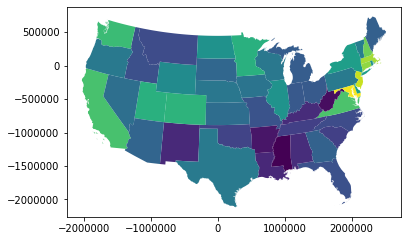

In [22]:
# Filter to continental US and reproject
gdf = gdf[~gdf["name"].isin(["Alaska", "Hawaii", "Puerto Rico"])].copy()
gdf.to_crs(epsg = 2163, inplace = True)

gdf.plot(column = "mhi")

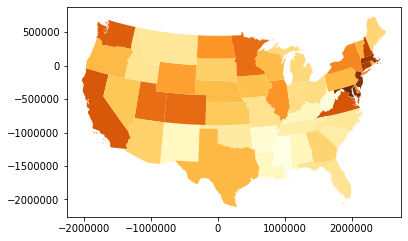

In [23]:
gdf.plot(column = "mhi", cmap = "YlOrBr")

In [24]:
# Get all the variables in a table
get_vars = ["NAME"] + ["B28010_" + str(i + 1).zfill(3) + "E" for i in range(7)]
print(get_vars)

['NAME', 'B28010_001E', 'B28010_002E', 'B28010_003E', 'B28010_004E', 'B28010_005E', 'B28010_006E', 'B28010_007E']


In [25]:
predicates = {}
predicates["get"] = ",".join(get_vars)
predicates["for"] = "county:*"
predicates["in"] = "state:42"
# predicates["key"] = ____________________

print(predicates)

{'get': 'NAME,B28010_001E,B28010_002E,B28010_003E,B28010_004E,B28010_005E,B28010_006E,B28010_007E', 'for': 'county:*', 'in': 'state:42'}


In [27]:
r = requests.get(base_url, params=predicates)

pa_counties = pd.DataFrame(columns=r.json()[0], data=r.json()[1:])

# Fix columns that should be numeric
pa_counties[pa_counties.columns[1:-2]] = pa_counties[pa_counties.columns[1:-2]].astype(int)

In [34]:
pa_counties["pct_has_computer"] = pa_counties["B28010_002E"] / pa_counties["B28010_001E"]


In [40]:
gdf2 = gpd.read_file("/home/lee/.cache/tigris/cb_2018_us_county_500k.shp")

gdf2.rename(columns = {"STATEFP": "state", "COUNTYFP": "county"}, inplace = True)
gdf2 = gdf2[["state", "county", "geometry"]]

gdf2 = gdf2.merge(pa_counties, on = ["state", "county"])
gdf2.to_crs(epsg = 2272, inplace = True)

In [41]:
gdf2.head()

,state,county,geometry,NAME,B28010_001E,B28010_002E,B28010_003E,B28010_004E,B28010_005E,B28010_006E,B28010_007E,pct_has_computer
0,42,005,"POLYGON ((1429579.553 492770.710, 1429725.759 ...","Armstrong County, Pennsylvania",27990,22823,20284,3806,19017,2539,5167,0.815398
1,42,029,"MULTIPOLYGON (((2574644.924 192143.254, 257521...","Chester County, Pennsylvania",189592,174348,164476,22285,152063,9872,15244,0.919596
2,42,035,"POLYGON ((1874022.399 686391.096, 1885045.137 ...","Clinton County, Pennsylvania",14744,12270,11056,2283,9987,1214,2474,0.832203
3,42,059,"POLYGON ((1190531.058 184452.197, 1190938.051 ...","Greene County, Pennsylvania",14211,11858,9997,1727,10131,1861,2353,0.834424
4,42,067,"POLYGON ((1969400.907 382984.850, 1970268.859 ...","Juniata County, Pennsylvania",9404,7430,6510,1370,6060,920,1974,0.790089


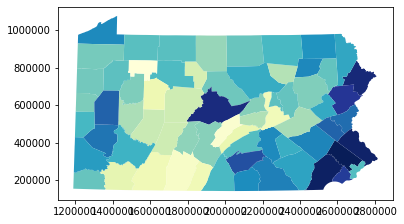

In [42]:
gdf2.plot(column = "pct_has_computer", cmap = "YlGnBu")